# Secunderabad City Road Map (OSM data)

In [59]:
import osmnx as ox
import math
import pandas as pd
import numpy as np
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from math import cos, asin, sqrt

### Graph of Hyderabad

In [5]:
g = ox.graph_from_file("test1.osm")

In [8]:
type(g)

networkx.classes.multidigraph.MultiDiGraph

### The road map system of hyderabad represented as nodes and edges

<Figure size 72x72 with 0 Axes>

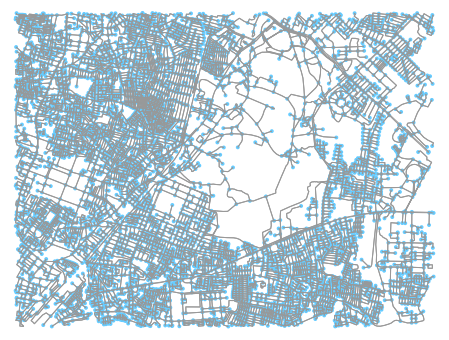

In [27]:
fig, ax = ox.plot_graph(g)

### All the edges in a graph

In [11]:
edges = ox.graph_to_gdfs(g, nodes=False, edges=True)

In [13]:
edges.head()

,access,area,bridge,geometry,highway,junction,key,landuse,lanes,length,maxspeed,name,oneway,osmid,ref,tunnel,u,v,width
0,NaN,NaN,NaN,"LINESTRING (78.5463503 17.4234715, 78.5464387 ...",residential,NaN,0,NaN,NaN,10.797,NaN,NaN,False,310483692,NaN,NaN,310444045,3159073204,NaN
1,NaN,NaN,NaN,"LINESTRING (78.5463503 17.4234715, 78.54606029...",residential,NaN,0,NaN,NaN,34.332,NaN,NaN,False,310483692,NaN,NaN,310444045,2236749077,NaN
2,NaN,NaN,NaN,"LINESTRING (78.5463503 17.4234715, 78.546391 1...",secondary,NaN,0,NaN,NaN,178.286,NaN,Nacharam road,True,166515441,NaN,NaN,310444045,2236749176,NaN
3,NaN,NaN,NaN,"LINESTRING (78.50797679999999 17.4197383, 78.5...",residential,NaN,0,NaN,NaN,40.275,NaN,NaN,False,354038206,NaN,NaN,3598254095,3598254112,NaN
4,NaN,NaN,NaN,"LINESTRING (78.5030998 17.4197063, 78.5026513 ...",residential,NaN,0,NaN,NaN,50.181,NaN,NaN,False,354037056,NaN,NaN,3598254093,1338912001,NaN


### Types of Edges that are Highways 

In [14]:
edges['highway'].value_counts()

residential                     19265
tertiary                         1109
service                           564
primary                           541
unclassified                      500
secondary                         428
trunk                             172
pedestrian                         70
footway                            28
track                              28
[residential, unclassified]        16
[service, residential]             16
trunk_link                         12
path                               12
primary_link                       10
road                               10
steps                               8
[footway, steps]                    8
[residential, tertiary]             6
[footway, steps, path]              4
[residential, steps]                4
[secondary, residential]            4
[primary, residential]              2
[service, residential, path]        2
[pedestrian, residential]           2
[primary, unclassified]             2
secondary_li

### Projection of the graph into metric system 

As the data is in WGS84 format, we might first want to reproject our data into metric system so that our map looks better

In [16]:
graph_proj = ox.project_graph(g)
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [20]:
edges_proj.head()

,access,area,bridge,geometry,highway,junction,key,landuse,lanes,length,maxspeed,name,oneway,osmid,ref,tunnel,u,v,width
0,NaN,NaN,NaN,LINESTRING (239353.3988310342 1928074.40447282...,residential,NaN,0,NaN,NaN,10.797,NaN,NaN,False,310483692,NaN,NaN,310444045,3159073204,NaN
1,NaN,NaN,NaN,LINESTRING (239353.3988310342 1928074.40447282...,residential,NaN,0,NaN,NaN,34.332,NaN,NaN,False,310483692,NaN,NaN,310444045,2236749077,NaN
2,NaN,NaN,NaN,LINESTRING (239353.3988310342 1928074.40447282...,secondary,NaN,0,NaN,NaN,178.286,NaN,Nacharam road,True,166515441,NaN,NaN,310444045,2236749176,NaN
3,NaN,NaN,NaN,LINESTRING (235269.5598519678 1927713.81906841...,residential,NaN,0,NaN,NaN,40.275,NaN,NaN,False,354038206,NaN,NaN,3598254095,3598254112,NaN
4,NaN,NaN,NaN,LINESTRING (234751.1535268353 1927717.03654308...,residential,NaN,0,NaN,NaN,50.181,NaN,NaN,False,354037056,NaN,NaN,3598254093,1338912001,NaN


In [19]:
nodes_proj.head()

,highway,lat,lon,osmid,x,y,geometry
310444045,NaN,17.4235,78.5464,310444045,239353,1.92807e+06,POINT (239353.3988310342 1928074.404472824)
3598254095,NaN,17.4197,78.508,3598254095,235270,1.92771e+06,POINT (235269.5598519678 1927713.819068414)
3598254093,NaN,17.4197,78.5031,3598254093,234751,1.92772e+06,POINT (234751.1535268353 1927717.036543082)
310444046,NaN,17.424,78.5471,310444046,239439,1.92813e+06,POINT (239438.9095684263 1928134.353834563)
3598254098,NaN,17.4197,78.5122,3598254098,235722,1.92771e+06,POINT (235722.1366581999 1927707.838840466)


In [24]:
print("NUMBER OF NODES",len(nodes_proj))
print("NUMBER OF EDGES",len(edges_proj))

NUMBER OF NODES 8351
NUMBER OF EDGES 23014


## Road path between Tarnaka and Amberpet

Tarnaka Secunderabad Latlong- 17.4234715, 78.5463503

Manikeshwari Nagar Amberpet, Secunderabad Latlong - 17.4202929, 78.5218057

### Haversine formula to Calculate the distance between two geographical points (Assuming Earth as a Globe)

In [197]:
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

### Haversine distance between Tarnaka and Amberpet

In [198]:
lat1 = 17.4234715; lat2 = 17.4202929; long1 = 78.5463503; long2 = 78.5218057
print("DISTANCE BETWEEN THE TWO LATLONGS IS: ", distance((lat1, long1), (lat2, long2)),"Kms" )

DISTANCE BETWEEN THE TWO LATLONGS IS:  2.6279111364840984 Kms


In [199]:
lat_nodes  = list(nodes_proj['lat'])
long_nodes = list(nodes_proj['lon'])

In [200]:
len(lat_nodes) == len(long_nodes)

True

In [201]:
start = []
for i in range(0,len(lat_nodes)):
    d = distance((lat_nodes[i],long_nodes[i]),(lat1,long1))
    start.append(d)

stop = []
for i in range(0,len(long_nodes)):
    d = distance((lat_nodes[i],long_nodes[i]),(lat2,long2))
    stop.append(d)

### Index of the minimum value in the list

In [209]:
a = start.index(min(start))
b = stop.index(min(stop))

In [210]:
a,b

(0, 100)

In [211]:
a = nodes_proj.index[a]
b = nodes_proj.index[b]

In [213]:
orig_xy = (nodes_proj.loc[a]['y'] , nodes_proj.loc[a]['x'])
target_xy = (nodes_proj.loc[b]['y'] , nodes_proj.loc[b]['x'])

### A and B are the closes nodes to Salar Jung and Charminar

In [214]:
route = nx.shortest_path(G=graph_proj, source=a, target=b, weight='length')

In [215]:
route

[310444045,
 3159073204,
 3159073194,
 3159073195,
 3205821595,
 3205821597,
 3205821598,
 1779592741,
 1779592744,
 3217011434,
 3598253855,
 3598254123,
 2241237686,
 5432705838,
 3598255378,
 3229462600,
 308613813,
 308613838,
 3598255563,
 309700136,
 3224405444,
 308613859,
 2578021683,
 308613865,
 3598254770,
 308613867,
 2240857239,
 2240857250,
 2240857254,
 2240857260,
 2240857264,
 2236748881,
 2236748883,
 2236748885,
 2236748888,
 2236748889,
 2236748853,
 2236748855,
 2236748861,
 4010670458,
 2236748837,
 3598254502,
 3598254319]

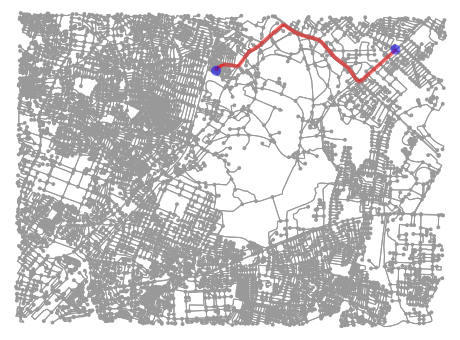

<Figure size 432x288 with 0 Axes>

In [216]:
fig, ax = ox.plot_graph_route(graph_proj, route, origin_point=orig_xy, destination_point=target_xy)
plt.tight_layout()